#autoencoder

In [1]:
import keras
from keras.layers import BatchNormalization, Activation, Input
from keras.layers import Reshape, UpSampling2D, Conv2D
from keras.models import Model
from keras.datasets import cifar10
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
#from keras.initializers import he_normal

def build_encoder(x):
    input_ = Input(x.shape[1:])

    c = Conv2D(32, (3, 3), padding="same", strides=2)(input_)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = Conv2D(64, (3, 3), padding="same", strides=2)(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = Conv2D(128, (3, 3), padding="same", strides=2)(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = Conv2D(256, (3, 3), padding="same", strides=2)(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = Conv2D(512, (3, 3), padding="same", strides=2)(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)

    return Model(inputs=input_, outputs=c)

def build_decoder(x):
    input_ = Input([int(x.shape[1]/16), int(x.shape[2]/16), 512])

    c = Conv2D(512, (3, 3), padding="same")(input_)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = UpSampling2D((2,2))(c)#4*4
    c = Conv2D(256, (3, 3), padding="same")(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = UpSampling2D((2,2))(c)#8*8
    c = Conv2D(128, (3, 3), padding="same")(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = UpSampling2D((2,2))(c)#16*16
    c = Conv2D(64, (3, 3), padding="same")(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = UpSampling2D((2,2))(c)#32*32
    c = Conv2D(32, (3, 3), padding="same")(c)
    c = BatchNormalization()(c)
    c = Activation("relu")(c)
    c = UpSampling2D((2,2))(c)#32*32

    c = Conv2D(3, (1, 1), padding="same")(c)
    c = BatchNormalization()(c)
    c = Activation("sigmoid")(c)

    return Model(inputs=input_, outputs=c)

def cifar():
    # dataset
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    return x_train, x_test, y_train, y_test

def train_autoencoder(x, epoch):
    encoder = build_encoder(x)
    decoder = build_decoder(x)
    input_ = Input(x.shape[1:])
    ae = Model(inputs = input_, outputs = decoder(encoder(input_)))

    ae.compile(loss='mse',
              optimizer=Adam())

    hist = ae.fit(x,
                  x,
                  batch_size=128,
                  epochs=epoch,
                  verbose = False)
    
    return ae, encoder

Using TensorFlow backend.


In [2]:
x_train, x_test, y_train, y_test = cifar()
#model, encoder = train_autoencoder(x_train)

170500096/170498071 [==============================] - 6s 0us/step


#CSG

In [0]:
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from keras.utils.np_utils import to_categorical
import seaborn as sns

def t_sne(x, label, encoder, fig=True):
    embed = encoder.predict(x)
    test_s = embed.reshape((len(embed),-1))

    X_reduced = TSNE(n_components=2).fit_transform(test_s)

    if fig == True:
        plt.figure(figsize=(12,10))
        plt.scatter(X_reduced[:, 0], X_reduced[:, 1],c=label.reshape(-1), cmap="jet")
        plt.colorbar()
        plt.show()

    return X_reduced
    
def random_choise(x, label, M=100, k=10):
    result_x, result_y = [], []

    for i in range(k):
        result = []
        for j in range(len(label)):
            if label[j] == i:
                result.append(j)
        
        number = np.random.choice(np.arange(0, len(result)), M, replace=False)
        for o in number:
                result_x.append(x[result[o]])
                result_y.append(i)
    return np.array(result_x), np.array(result_y)
                                        
def p_cj(xi, xj, M=100, V=1):
    neigh = KNeighborsClassifier(n_neighbors=3)
    X = np.vstack((xi,xj))
    y = np.zeros(len(xi)+len(xj))
    y[len(xi):] = 1
    neigh.fit(X, y) 
    return M*np.mean(neigh.predict_proba(xj)[:,0])/(M*V)

def make_S(embed, label, k=10):
    S=np.eye(k)

    for i in range(k):
        for j in range(k):
            if i == j:
                pass
            else:
                class_i, class_j = [], []
                for o in range(len(label)):
                    if label[o] == i:
                        class_i.append(embed[o])
                    elif label[o] == j:
                        class_j.append(embed[o])
                S[i,j] = p_cj(class_i, class_j)

    return S

def w_ij(S, k=10):
    W = np.eye(k)
    #上三角だけ計算
    for i in range(k-1):
        for j in range(i, k):
            W[i,j] = 1 - np.sum(np.abs(S[i,:]-S[j,:])) / np.sum(np.abs(S[i,:]+S[j,:]))

    #下三角はコピー
    for i in range(1,k):
        for j in range(0,i+1):
            W[i,j] = np.copy(W[j,i])

    return W

def csg(W, k=10):
    # D
    sum_W = np.sum(W, axis=0)
    D = np.zeros((k,k))
    for i in range(k):
        D[i,i] = sum_W[i]

    # csg
    L = D-W
    eig = np.linalg.eig(L)[0]
    eig = np.sort(eig)

    eig_norm=[]
    for i in range(k-1):
        eig_norm.append((eig[i+1]-eig[i])/(k-i))

    # cummax
    result_csg = []
    for i in range(len(eig_norm)):
        result_csg.append(np.max(eig_norm[:i+1]))

    return np.sum(result_csg)

#MDS

In [0]:
from sklearn import manifold
from matplotlib.collections import LineCollection

#cifar10のラベル
mds_label = ['airplane',
             'automobile',
             'bird',
             'cat',
             'deer',
             'dog',
             'frog',
             'horse',
             'ship',
             'truck']

def MDS(W):
    #mds
    mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                       dissimilarity="precomputed", n_jobs=1)
    pos = mds.fit(1-W).embedding_

    plt.figure(figsize=(5,5))
    ax = plt.axes([0., 0., 1., 1.])

    for (xx, yy), l in zip(pos, mds_label):
        plt.text(xx, yy, l, fontsize=20)

    segments = [[pos[i, :], pos[j, :]]
                for i in range(len(pos)) for j in range(len(pos))]
    lc = LineCollection(segments,
                        zorder=0, cmap=plt.cm.Blues,
                        norm=plt.Normalize(0, 0.5))
    lc.set_linewidths(np.full(len(segments), 0.5))
    ax.add_collection(lc)
    plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', lw=0, label='MDS')
    plt.axis("off")
    plt.show()

#evaluate
















data size= 500 : csg= 6.015213620723347
data size= 1500 : csg= 6.412724160313804
data size= 2500 : csg= 6.1526051663754195
data size= 3500 : csg= 6.08802035950055
data size= 4500 : csg= 6.036165333516462
data size= 5000 : csg= 5.932139895600515


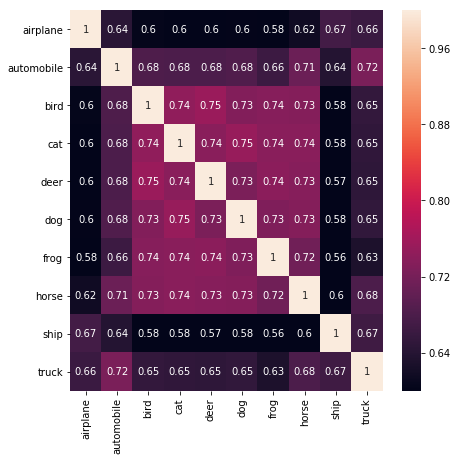

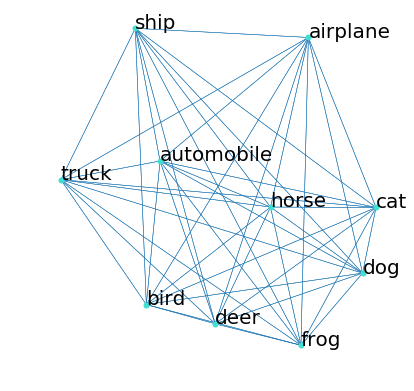

In [0]:
for size in [500, 1500, 2500, 3500, 4500, 5000]:
    result_W = np.zeros((10,10))
    x_train_small, y_train_small = random_choise(x_train, y_train, M=size)
    CSG = []
    model, encoder = train_autoencoder(x_train_small, int(50*5000/size))
    for k in range(5):
        X_test, Y_test = random_choise(x_test, y_test)
        #print(np.sum(to_categorical(Y_test), axis=0))

        for i in range(5):
            X_tsne = t_sne(X_test, Y_test, encoder, fig=False)
            S = make_S(X_tsne, Y_test)
            W = w_ij(S)
            CSG.append(csg(W))
            result_W += W
    print("data size=", size, ": csg=",np.mean(CSG))

    # MDS
    if size == 5000:
        result_W /= 25
        plt.figure(figsize=(7,7))
        sns.heatmap(result_W, annot=True, xticklabels=mds_label, yticklabels=mds_label, vmin=0.6, vmax=1)
        plt.show()

        MDS(result_W)